# DEA CoastLines validation

To do:
* [ ] Change output CRS to Australian Albers

In [24]:
# import xarray as xr
# from shapely.geometry import Point, LineString


## Load modules/functions


In [66]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import glob
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from shapely.geometry import box
import geopandas as gpd

import deacoastlines_validation as deacl_val

import sys
sys.path.append("/g/data/r78/rt1527/dea-notebooks/MAHTS/")
import deacoastlines_statistics as deacl_stats

def to_vector(df, fname='test.shp', x='x', y='y', crs='EPSG:28356'):
    
    # Convert datetimes to strings
    is_datetime = df.dtypes == 'datetime64[ns]'
    df.loc[:, is_datetime] = df.loc[:, is_datetime].astype(str) 
    
    # Export to file
    gpd.GeoDataFrame(data=df.loc[:, df.dtypes != 'datetime64[ns]'],
                     geometry=gpd.points_from_xy(x=df[x], y=df[y]),
                     crs=crs).to_file(fname)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pre-processing

### NSW Beach Profile Database



In [ ]:
for fname in glob.glob('input_data/nswbpd/*Stockton*.csv'):
    deacl_val.preprocess_nswbpd(fname, datum=0.5, overwrite=True)     


## WRL Narrabeen 

In [ ]:
deacl_val.preprocess_narrabeen(fname='input_data/wrl/Narrabeen_Profiles_2018.csv',
                               overwrite=True)


## City of Gold Coast

In [ ]:
# List of sites to iterate over
all_profiles = glob.glob(f'input_data/cityofgoldcoast/*.txt')
sites = np.unique([i.split(' - ')[0].split('/')[-1] for i in all_profiles])
# sites = ['SOUTH STRADBROKE']

for site in sites:
    deacl_val.preprocess_cgc(site=site, overwrite=True)

## TASMARC

In [ ]:
# List of sites to iterate over
sites = [i.split('/')[2] for i in glob.glob('input_data/tasmarc/*/')]

for site in sites:
    deacl_val.preprocess_tasmarc(site, overwrite=True) 


## SA Department of Environment and Water

In [ ]:
import math
from pyproj import Transformer

# Load data and set nodata values to NaN
wide_df = pd.read_csv('input_data/sadew/200011.CSV', na_values=[-9999])

# Reproject coords to Albers and create geodataframe
trans = Transformer.from_crs("EPSG:28354", "EPSG:28356", always_xy=True)
wide_df['EASTING'], wide_df['NORTHING'] = trans.transform(
    wide_df.EASTING.values, wide_df.NORTHING.values)

# Reshape into long format with each observation on a new row
profile_df = pd.melt(wide_df.drop('SAMPLE_NO', axis=1), 
                     id_vars=['EASTING', 'NORTHING', 'PROFILE'],
                     value_name='elevation').dropna()

# Set column names to lower case
profile_df.columns = profile_df.columns.str.lower()

# Extract date info
profile_df['date'] = profile_df['variable'].str[1:].str.strip()
profile_df['date'] = pd.to_datetime(profile_df['date'], format='%d%m%Y')

# Restrict to post 1987
profile_df = profile_df[(profile_df.date.dt.year > 1987)]

# Add unique ID column
profile_df['beach'] = 'sadew'
profile_df['section'] = 'all'
profile_df['profile'] = profile_df['profile'].astype(str)
profile_df['site'] = profile_df[['beach', 'section', 'profile']].apply('_'.join, 1)
profile_df['source'] = 'sadew'

# Compute origin points for each profile
profile_df = profile_df.assign(start_x=wide_df.iloc[0, 2], 
                               start_y=wide_df.iloc[0, 3],
                               end_x=wide_df.iloc[-1, 2],
                               end_y=wide_df.iloc[-1, 3])

# Compute chainage
profile_df['chainage'] = profile_df.apply(
    lambda x: math.hypot(x.easting - x.start_x, x.northing - x.start_y), axis=1)

In [ ]:
# Find location and distance to water for datum height (0 m AHD)
out = profile_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
                                                  dist_col='chainage',
                                                  x_col='easting', 
                                                  y_col='northing', 
                                                  z_col='elevation', 
                                                  z_val=0).dropna()

# If the output contains data
if len(out.index):

    # Join into dataframe
    shoreline_dist = out.join(
        profile_df.groupby(['site', 'date']).first())

    # Keep required columns
    shoreline_dist = shoreline_dist[['beach', 'section', 'profile',  
                                     'source', 'start_x', 'start_y', 
                                     'end_x', 'end_y', '0_dist', 
                                     '0_x', '0_y']]

    # Export to file
    shoreline_dist.to_csv(f'output_data/satest.csv')

## WA DoT

### Perth transects

In [26]:
from shapely.geometry import Point, LineString

# util functions
def perpendicular_line(l1, length):
    """Create a new LineString perpendicular to <l1> with length <length>."""
    dx = l1.coords[1][0] - l1.coords[0][0]
    dy = l1.coords[1][1] - l1.coords[0][1]

    p = Point(l1.coords[0][0] + 0.5 * dx, l1.coords[0][1] + 0.5 * dy)
    x, y = p.coords[0][0], p.coords[0][1]

    if (dy == 0) or (dx == 0):
        a = length / l1.length
        l2 = LineString([(x - 0.5 * a * dy, y - 0.5 * a * dx),
                         (x + 0.5 * a * dy, y + 0.5 * a * dx)])

    else:
        s = -dx / dy
        a = ((length * 0.5) ** 2 / (1 + s ** 2)) ** 0.5
        l2 = LineString([(x + a, y + s * a),
                         (x - a, y - s * a)])

    return l2

def transect_at_reg_intervals(line, interval, trans_length, res):
    """get perpendicular lines (transects) at regular <interval> along line
    (shapely LineString/MultiLineString)"""
    dl = max(res/2., 0.5) # res argument required to determin length of tangent lines
    intervals = np.arange(dl, line.length, interval)
    tangent_lines = [LineString(line.interpolate(dist-dl).coords[:] + line.interpolate(dist+dl).coords[:])
                      for dist in intervals+dl]
    return intervals, [perpendicular_line(l1, trans_length) for l1 in tangent_lines]




In [34]:
tertiary_gdf = gpd.read_file('input_data/WA_tertiaryCC.shp').to_crs('EPSG:3577')

for i, compartment in tertiary_gdf.iloc[:].iterrows():
    print(i, compartment.FROM_)

0 Cape Bougainville
1 Un-named Head
2 Cape Rulhieres
3 Cape Bernier
4 Davidsons Point
5 Augereau Island
6 Swift Bay
7 Elsie Island N
8 Cape Londonderry
9 Cape Talbot
10 Low Island Point
11 Anjo
12 Drysdale River
13 Crystal Head
14 Marnebulorgne Community N point
15 Packer Island
16 Swan Island
17 Point Usborne
18 Meda River mouth spit SW
19 Chimney Rocks
20 Helpman Island
21 Red Bluff
22 Malaburra Spring
23 Cornambie Point
24 Point Torment
25 Combe Hill Point
26 East Cape Domett
27 Bare Hill
28 Thurburn Bluff
29 Cape Wellington
30 Aunty Islet
31 Cape Torrens
32 High Bluff
33 Battery Point
34 Raft Point
35 Anderdon Islands Point
36 Un-named Promontory
37 Shale Island
38 Nares Point
39 Conilurus Island
40 Sir Richard Island
41 Un-named Peninsular
42 Saddle Hill
43 Cape Gourdon
44 Cooraidegel Well coast
45 Yan Well coast
46 Shoonta Well
47 Wattle Well coast
48 Condini Landing
49 Cape Keraudren
50 Beebingara Creek coast E
51 Dorre Island and Bernier Island
52 Rottnest Island, Carnac Island

In [120]:
for i, _ in tertiary_gdf.iloc[:].iterrows():
    
    # Extract compartment as a GeoDataFrame so it can be used to clip other data
    compartment = tertiary_gdf.iloc[[i]]
    beach = compartment.FROM_.str.replace(' ', '').str.replace('/', '').str.lower().iloc[0]
    print(f'{beach:<80}', end='\r')
    
    # Read file and filter to AHD 0 shorelines
    val_gdf = gpd.read_file('input_data/wadot/Coastline_Movements_20190819.gdb', 
                            bbox=compartment).to_crs('EPSG:3577')
    val_gdf = val_gdf[(val_gdf.TYPE == 'AHD 0m') | (val_gdf.TYPE == 'AHD 0m ')]

    # Filter to post 1987 shorelines and set index to year
    val_gdf = val_gdf[val_gdf.PHOTO_YEAR > 1987]
#     val_gdf = val_gdf[val_gdf.PHOTO_YEAR != 2000]
#     val_gdf = val_gdf[val_gdf.PHOTO_YEAR != 2007]
    val_gdf = val_gdf.set_index('PHOTO_YEAR')

    # If no data is returned, skip this iteration
    if len(val_gdf.index) == 0:
        print(f'Failed: {beach:<80}', end='\r')
        continue

    ######################
    # Generate transects #
    ######################

    # Load smartline
    smartline_gdf = gpd.read_file('../input_data/Smartline.gdb',
                                  bbox=compartment).to_crs('EPSG:3577')
    comp_contour = smartline_gdf.geometry.unary_union.simplify(200)

    # Load Australian land water polygon
    land_gdf = gpd.read_file('/g/data/r78/rt1527/shapefiles/australia/australia/cstauscd_r.shp', 
                             bbox=compartment).to_crs('EPSG:3577')
    land_gdf = land_gdf.loc[land_gdf.FEAT_CODE.isin(["mainland", "island"])]
    land_shapely = gpd.overlay(df1=land_gdf, 
                               df2=compartment).unary_union

    # Extract transects along line
    values, geoms = transect_at_reg_intervals(line=comp_contour, 
                                              interval=200,
                                              trans_length=500, 
                                              res=30)

    # Test if end points of transects fall in water or land
    p1 = gpd.GeoSeries([Point(i.coords[0]) for i in geoms])
    p2 = gpd.GeoSeries([Point(i.coords[1]) for i in geoms])
    p1_within_land = p1.within(land_shapely)
    p2_within_land = p2.within(land_shapely)

    # Create geodataframe and remove invalid transects (land-land or water-water)
    transect_gdf = gpd.GeoDataFrame(data={'p1': p1_within_land, 
                                          'p2': p2_within_land}, 
                                    geometry=geoms, 
                                    crs=val_gdf.crs)
    transect_gdf = transect_gdf[~(transect_gdf.p1 == transect_gdf.p2)]

    # Reverse transects so all point away from land
    transect_gdf['geometry'] = transect_gdf.apply(
        lambda i: LineString([i.geometry.coords[1], 
                              i.geometry.coords[0]]) if i.p1 < i.p2 else i.geometry, axis=1)  


    ################################
    # Identify 0 MSL intersections #
    ################################

    output_list = []

    # Select one year
    for year in val_gdf.index.unique().sort_values(): 

        # Extract validation contour
        print(f'{beach} {year}', end='\r')
        val_contour = val_gdf.loc[[year]].geometry.unary_union

        # Copy transect data, and find intersects between transects and contour
        intersect_gdf = transect_gdf.copy()
        intersect_gdf['val_point'] = transect_gdf.intersection(val_contour)
        to_keep = gpd.GeoSeries(intersect_gdf['val_point']).geom_type == 'Point'
        intersect_gdf = intersect_gdf.loc[to_keep]
        
        # If no data is returned, skip this iteration
        if len(intersect_gdf.index) == 0:
            print(f'Failed: {beach} {year:<80}', end='\r')
            continue

        # Add generic metadata
        intersect_gdf['date'] = pd.to_datetime(str(year))
        intersect_gdf['beach'] = beach
        intersect_gdf['section'] = 'all'
        intersect_gdf['profile'] = list(map(str, range(0, len(intersect_gdf.index))))
        intersect_gdf['source'] = 'photogrammetry' 
        intersect_gdf['site'] = intersect_gdf[['beach', 'section', 'profile']].apply('_'.join, 1)

        # Add measurement metadata
        intersect_gdf[['start_x', 'start_y']] = intersect_gdf.apply(
            lambda x: pd.Series(x.geometry.coords[0]), axis=1)
        intersect_gdf[['end_x', 'end_y']] = intersect_gdf.apply(
            lambda x: pd.Series(x.geometry.coords[1]), axis=1)
        intersect_gdf['0_dist'] = intersect_gdf.apply(
            lambda x: Point(x.start_x, x.start_y).distance(x['val_point']), axis=1)
        intersect_gdf[['0_x', '0_y']] = intersect_gdf.apply(
            lambda x: pd.Series(x.val_point.coords[0]), axis=1)

        # Keep required columns
        intersect_gdf = intersect_gdf[['site', 'date', 'beach', 'section', 'profile',  
                                       'source', 'start_x', 'start_y', 
                                       'end_x', 'end_y', '0_dist', 
                                       '0_x', '0_y']]

        # Append to file
        output_list.append(intersect_gdf)

    # Combine all year data and export to file
    if len(output_list) > 0:
        shoreline_df = pd.concat(output_list)
        shoreline_df.to_csv(f'output_data/wadot_{beach}.csv', index=False)


In [241]:
# Read data
profiles_df = pd.read_csv('input_data/vicdeakin/z_data_10cm_VIC.csv').dropna()

# Optionally restrict to profile
profiles_df = profiles_df.loc[profiles_df.location == 'leo'].reset_index(drop=True)

In [242]:
profiles_df.to_csv('test.csv')

## Victoria/Deakin

In [86]:
deacl_val.preprocess_vicdeakin(fname='input_data/vicdeakin/z_data_10cm_VIC.csv',
                               datum=0)

output_data/vicdeakin_apo.csv
output_data/vicdeakin_cow.csv
output_data/vicdeakin_inv.csv
output_data/vicdeakin_leo.csv
output_data/vicdeakin_mar.csv
output_data/vicdeakin_pfa.csv
output_data/vicdeakin_por.csv
output_data/vicdeakin_prd.csv
output_data/vicdeakin_sea.csv
output_data/vicdeakin_wbl.csv


## Analysis
To investigate:
* [ ] Outlier in Bermagui (Horseshoe Bay)
* [ ] Multiple outliers in Boambee Beach
* [ ] Single remaining outlier in Bogangar to Kingscliff
* [ ] **Cluster of outliers in Burgess Beach: caused by one year of channel profiles**
* [ ] Sporadic outliers in Byron Bay
* [ ] Two remaining outlier in Corindi Beach
* [ ] **Major outliers at Crowdy Head**
* [ ] **String of outliers in opposite direction at Cullendulla**
* [ ] One remaining outlier at Diamond Beach
* [ ] One remaining outlier at Eurobadalla Beaches North
* [ ] **Cluster of outliers at Evans Head and Broadwater**
* [ ] Two outliers in Fern Bay
* [ ] **Extreme outliers at Flynn's Beach**
* [ ] **Skewed result at Gerringong Harbour**
* [ ] Outliers in Hargrave's Beach
* [ ] Remaining outliers at Jimmy's Beach
* [ ] **Remaining major outlier at Lake Illawarra**
* [ ] **Outliers in Manly Beach**
* [ ] Outliers at Mooney Beach
* [ ] **Major issues with offset shorelines at Narrabeen/Collory**
* [ ] **Outliers in opposite direction at Park's Beach**
* [ ] Cluster of outliers at Patch's Beach
* [ ] Port Hacking currently excluded from DEACL by estuary mask
* [ ] **Weird line of points at Rainbow Beach**
* [ ] **No relationship at Sandbar Beach**
* [ ] One remaining outlier at Stuart's Point
* [ ] **Several remaining outliers at Swansea Belmont**
* [ ] **Cluster of outliers at The Entrance**
* [ ] Single outlier at Warrain

,id,rmse,mae,r2,cor
0,vicdeakin_prd,13.879297,12.851126,-1.290823,0.913220
1,vicdeakin_inv,22.253249,20.283759,-1.094297,0.872726
2,vicdeakin_leo,5.012117,3.923385,0.157985,0.744357
3,vicdeakin_mar,5.795482,4.821893,0.097684,0.639234
4,vicdeakin_pfa,23.400641,22.697267,-10.380047,0.577778


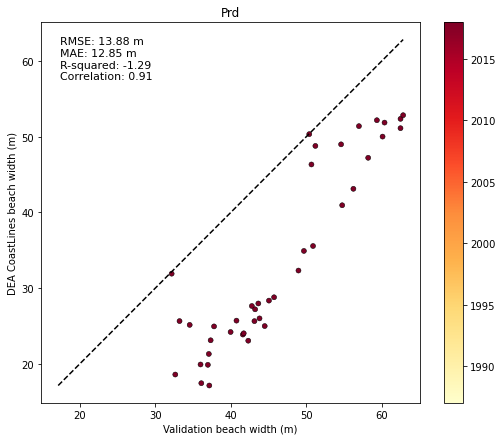

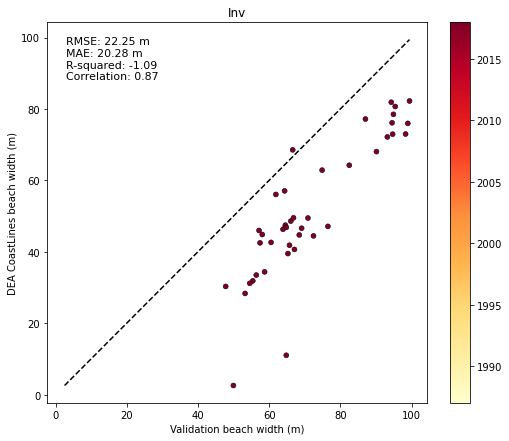

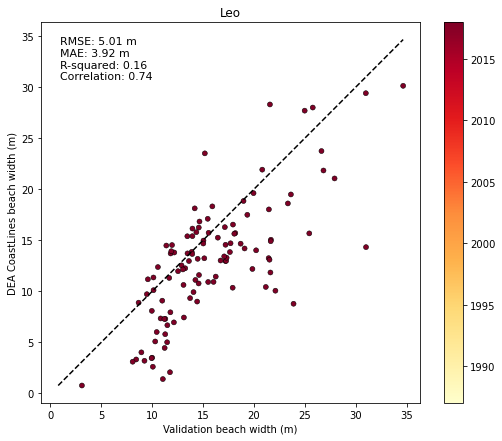

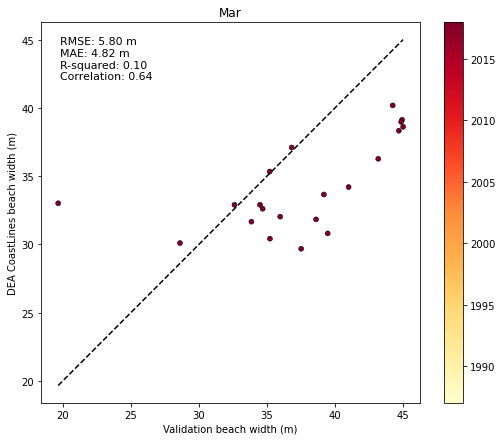

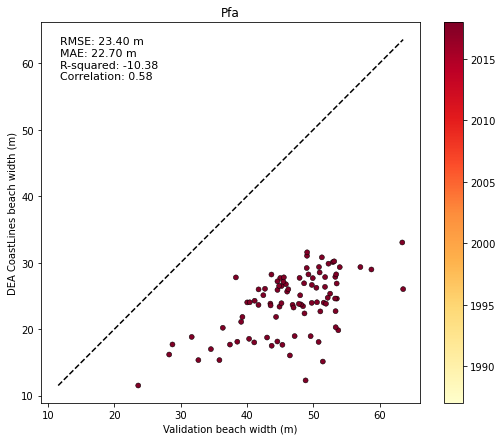

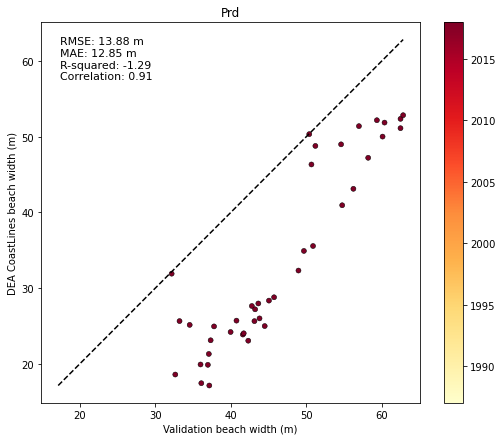

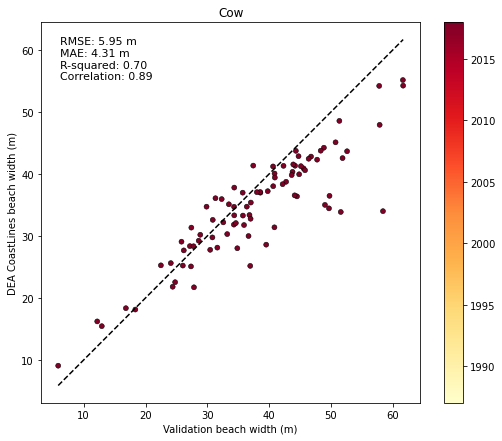

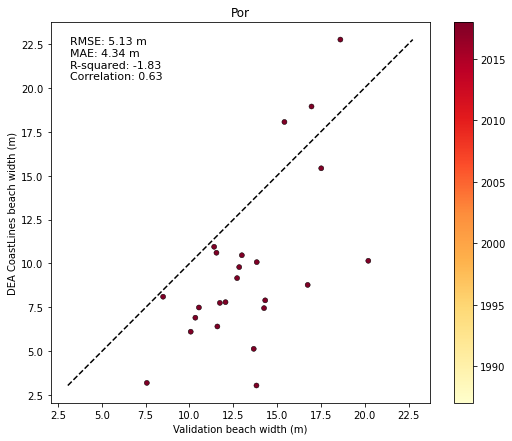

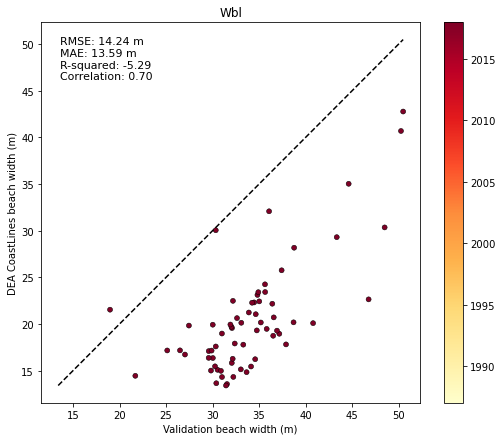

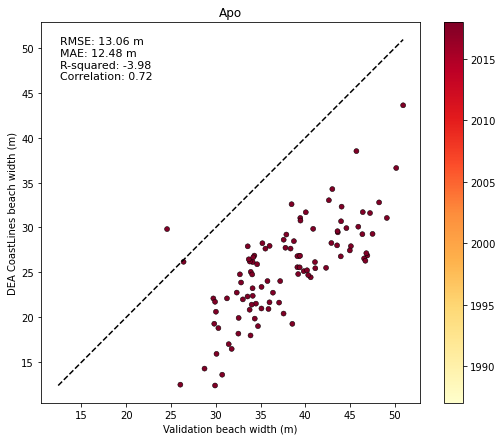

In [89]:
val_paths = glob.glob('output_data/vicdeakin_*.csv')
deacl_path = '../packages/DEACoastLines_v0.2.0/DEACoastLines_coastlines_v0.2.0.shp'
# deacl_path = '../DEACoastLines_coastlines_v0.2.0_0.20.shp'

stats_list = []

for val_path in val_paths:
    
    # Run analysis and close resulting figure
    print(f'{val_path:<80}', end='\r')
    output_stats = deacl_val.deacl_validation(val_path, 
                                              deacl_path,
                                              datum=0,
                                              sat_offset=0, 
                                              return_df=False,
                                              eval_shapes=True)
    # Close figure if plotting over 10
    if len(stats_list) > 10: plt.close()
    
    # Append stats to list
    stats_list.append(output_stats)
    
# Combine stats into a dataframe
stats_df = pd.DataFrame([stats for stats in stats_list if stats])
stats_df.head()


In [11]:
test = gpd.read_file('/g/data/r78/rt1527/dea-notebooks/MAHTS/validation/figures/eval/vicdeakin_apo_val_points.geojson')

In [150]:
pd.DataFrame(test)

,site,year,0_x,0_y,Validation beach width (m),DEA CoastLines beach width (m),geometry
0,apo_all_0,2018,1.023339e+06,-4.284704e+06,29.436746,17.822739,POINT (143.67440 -38.75807)
1,apo_all_1,2018,1.023320e+06,-4.284697e+06,16.878029,10.880968,POINT (143.67417 -38.75802)
2,apo_all_10,2018,1.023168e+06,-4.284645e+06,24.617659,21.042505,POINT (143.67240 -38.75768)
3,apo_all_100,2018,1.023543e+06,-4.283061e+06,14.711952,20.204567,POINT (143.67501 -38.74302)
4,apo_all_101,2018,1.023558e+06,-4.283047e+06,11.975408,20.594622,POINT (143.67516 -38.74288)
...,...,...,...,...,...,...,...
96,apo_all_95,2018,1.023479e+06,-4.283138e+06,15.034278,26.871595,POINT (143.67437 -38.74377)
97,apo_all_96,2018,1.023492e+06,-4.283122e+06,15.294211,27.953968,POINT (143.67449 -38.74362)
98,apo_all_97,2018,1.023504e+06,-4.283107e+06,16.030286,32.724323,POINT (143.67461 -38.74346)
99,apo_all_98,2018,1.023519e+06,-4.283093e+06,12.596683,19.132199,POINT (143.67477 -38.74333)


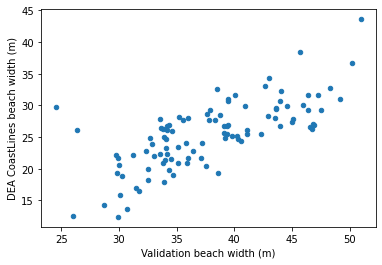

In [12]:
pd.DataFrame(test).plot.scatter(x='Validation beach width (m)', y='DEA CoastLines beach width (m)')

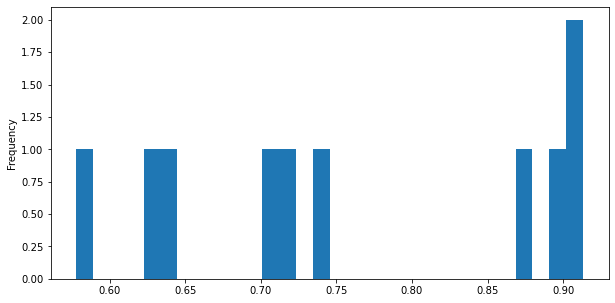

In [7]:
stats_df['cor'].plot.hist(bins=30, figsize=(10, 5))  #, range=(0, 100))

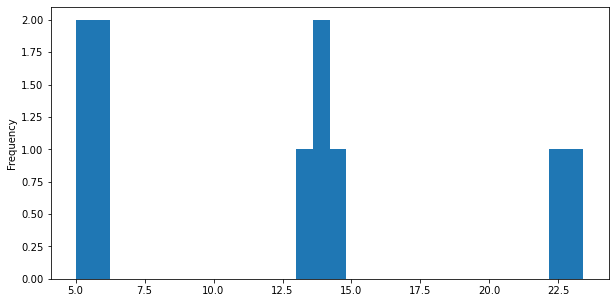

In [8]:
stats_df['rmse'].plot.hist(bins=30, figsize=(10, 5))  #, range=(0, 100))

In [10]:
stats_df['rmse'].median()

13.471810132890639

## Testing NSWBPD

In [ ]:
fname = 'input_data/nswbpd/photogrammetry_Xsections_Burril Lake and Racecourse Beach.csv'

# Get output filename
name = Path(fname).stem.split('_')[-1].lower().replace(' ', '')
fname_out = f'output_data/nswbpd_{name}.csv'

# Read in data
print(f'Processing {fname_out}             ', end='\r')            
profiles_df = pd.read_csv(fname, skiprows=5)
profiles_df['Year/Date'] = pd.to_datetime(profiles_df['Year/Date'],
                                          dayfirst=True,
                                          errors='coerce')

# Restrict to post 1987
profiles_df = profiles_df[profiles_df['Year/Date'] > '1987']

# Convert columns to strings and add unique ID column
profiles_df['Beach'] = profiles_df['Beach'].str.lower().str.replace(' ', '')
profiles_df['Block'] = profiles_df['Block'].astype(str).str.lower()
profiles_df['Profile'] = profiles_df['Profile'].astype(str).str.lower()
profiles_df['site'] = profiles_df[['Beach', 'Block',
                                   'Profile']].apply('_'.join, 1)

# Rename columns
profiles_df.columns = ['beach', 'section', 'profile', 'date', 'chainage', 
                       'elevation', 'easting', 'northing', 'source', 'site']

# # Compute origin points for each profile
# start_xy = profiles_df.loc[profiles_df.groupby(['site']).chainage.idxmin(), 
#                             ['site', 'easting', 'northing']]
# start_xy = start_xy.rename({'easting': 'start_x', 
#                             'northing': 'start_y'}, axis=1)
# start_xy = start_xy.reset_index(drop=True)

# # Compute end points for each profile
# end_xy = profiles_df.loc[profiles_df.groupby(['site']).chainage.idxmax(), 
#                          ['site', 'easting', 'northing']]
# end_xy = end_xy.rename({'easting': 'end_x', 
#                         'northing': 'end_y'}, axis=1)
# end_xy = end_xy.reset_index(drop=True)

# # Join origin and end points into dataframe
# profiles_df = pd.merge(left=profiles_df, right=start_xy)
# profiles_df = pd.merge(left=profiles_df, right=end_xy)

# # Find location and distance to water for datum height (0 m AHD)
# out = profiles_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
#                                                   dist_col='chainage',
#                                                   x_col='easting', 
#                                                   y_col='northing', 
#                                                   z_col='elevation', 
#                                                   z_val=0).dropna()

In [ ]:
profiles_sub = profiles_df[(profiles_df.site == 'burrillakeandracecoursebeach_1_5') & (profiles_df.date == '1993-05-14') ]  

In [ ]:
burrillakeandracecoursebeach_1_5

In [ ]:
to_vector(profiles_df, x='easting', y='northing', fname='test6.shp')

## Testing GCC

In [ ]:
results_df


results_df[(results_df.site == 'broadbeach_eta_59') ]

In [ ]:
pd.read_csv(val_paths[0], parse_dates=['date'], index_col='site').loc['broadbeach_eta_58.50']

In [ ]:
 x.geometry_val.intersection(x.geometry_deacl)
            .hausdorff_distance(Point(x.start_x, x.start_y)), axis=1)


In [ ]:
gpd.GeoSeries(results_df.loc[results_df.site == 'broadbeach_eta_59'].iloc[0].geometry_val).plot()


gpd.GeoSeries(results_df.loc[results_df.site == 'broadbeach_eta_59'].iloc[0].geometry_val.interpolate(219)).plot(ax=plt.gca())

In [ ]:
results_df.loc[results_df.site == 'broadbeach_eta_59'].iloc[0].geometry_val.length

In [ ]:
profile_i = '/g/data/r78/rt1527/dea-notebooks/MAHTS/validation/input_data/cityofgoldcoast/BROADBEACH - ETA 59 - (13474) 1996-06-05.txt'


pd.read_csv(profile_i,
                                 usecols=[1, 2, 3],
                                 delim_whitespace=True, 
                                 names=['x', 'y', 'z']).plot.scatter(x='x', y='z')

In [ ]:
profile_list 

In [ ]:
profile_list = glob.glob(f'input_data/cityofgoldcoast/SOUTH STRADBROKE - SSI 09 *.txt')

# Output list to hold data
site_profiles = []

for profile_i in profile_list:

    # Identify unique field values from file string
    profile_string = os.path.basename(profile_i)

    # Treat data file string differently depending on format
    if len(profile_string.split(' - ')) > 3:
        beach, section, profile, id_date = profile_string.split(' - ')            

    else:
        beach, section_profile, id_date = profile_string.split(' - ')

        if len(section_profile.split(' ')) == 2:
            section, profile = section_profile.split(' ')

        else:
            section, profile = 'none', section_profile

    # If beach name is in the list of problematic names, replace
    beach = manual_rename[beach] if beach in manual_rename.keys() else beach

    # Remove any special characters from beach/section/profile names and create ID 
    profile_df = pd.read_csv(profile_i,
                             usecols=[1, 2, 3],
                             delim_whitespace=True, 
                             names=['x', 'y', 'z'])
    profile_df['date'] = pd.to_datetime(id_date[-14:-4]) 
    profile_df['source'] = 'hydrographic survey'
    profile_df['profile'] = profile.lower()
    profile_df['section'] = section.lower()
    profile_df['beach'] = beach.replace(' ', '').lower()
    profile_df['site'] = profile_df[['beach', 'section', 'profile']].apply('_'.join, 1)

    # Filter to drop pre-1987 and deep water samples, add to list if any 
    # data is available above 0 MSL
    profile_df = profile_df[profile_df.z > -3.0]
    profile_df = profile_df[profile_df.date > '1987']    
    if profile_df.z.max() > 0:
        site_profiles.append(profile_df)

# Combine into a single dataframe
profiles_df = pd.concat(site_profiles)

# Compute origin and end points for each profile
start_xy = profiles_df.groupby(['site'], as_index=False).first()[['site', 'x', 'y']]
end_xy = profiles_df.groupby(['site'], as_index=False).last()[['site', 'x', 'y']]
start_xy = start_xy.rename({'x': 'start_x', 'y': 'start_y'}, axis=1)
end_xy = end_xy.rename({'x': 'end_x', 'y': 'end_y'}, axis=1)

# Join origin and end points into dataframe
profiles_df = pd.merge(left=profiles_df, right=start_xy)
profiles_df = pd.merge(left=profiles_df, right=end_xy)

# # Compute chainage
# profiles_df['chainage'] = profiles_df.apply(
#     lambda x: math.hypot(x.x - x.start_x, x.y - x.start_y), axis = 1)

# # Find location and distance to water for datum height (0 m AHD)
# out = profiles_df.groupby(['site', 'date']).apply(deacl_val.waterline_intercept, 
#                                                   dist_col='chainage',
#                                                   x_col='x', 
#                                                   y_col='y', 
#                                                   z_col='z', 
#                                                   z_val=0).dropna()

In [ ]:
profiles_subset = profiles_df.loc[profiles_df.date.dt.year == 2013]
profiles_subset.plot(x='x', y='z')

In [ ]:
to_vector(profiles_df.loc[profiles_df.date.dt.year == 2013], fname='test4.shp')



    

In [ ]:
merge_test.groupby('year').median().reset_index().plot(x='year', y='DEA CoastLines beach width (m)')
merge_test.groupby('year').median().reset_index().plot(x='year', y='Validation beach width (m)', ax=plt.gca())

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020